# Example 8 - Spline Tension

Apply spline tension to interpolaton, gradient, derivative, or smoothing routines to reduce the occurance of undershoot / overshoot inconsistencies in the solution.

The values to determine the degree of tension is stored in `sigma`. Using the routine `get_spline_tension_factors` will determine the smallest tension factor such that the spline preserves the local shape properties (monotonicity and convexity) of the data. If `sigma` is zero everywhere, then no tension is active.

We walk through a number of routines that we have explored in previous notebooks, but in this case demonstrating the use of tensioned splines.

## Contents

- [Smoothing with tension](#Smoothing-with-tension)
- [Interpolation with tension](#Interpolation-with-tension)
- [Gradients with tension](#Gradients-with-tension)

In [1]:
import stripy as stripy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

In [2]:
mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=4)

In [3]:
def analytic(lons, lats, k1, k2):
     return  np.cos(k1*lons) * np.sin(k2*lats) 

def analytic_noisy(lons, lats, k1, k2, noise, short):
     return  np.cos(k1*lons) * np.sin(k2*lats) + short * (np.cos(k1*5.0*lons) * np.sin(k2*5.0*lats)) +  noise * np.random.random(lons.shape)

data   = analytic(mesh.lons, mesh.lats, 5.0, 2.0)
data_n = analytic_noisy(mesh.lons, mesh.lats, 5.0, 2.0, 0.1, 0.0)

In [4]:
# get tension factors from the data
sigma   = mesh.get_spline_tension_factors(data, tol=1e-6)
sigma_n = mesh.get_spline_tension_factors(data_n, tol=1e-6)

## Smoothing with tension

Tension is applied simply by supplying `sigma`. It's effect is most noticible near the poles where there are edge artefacts in the solution.

In [5]:
stripy_smoothed,  dds, err = mesh.smoothing(data, np.ones_like(data_n), 10.0, 0.1, 0.01)
stripy_smoothed2, dds, err = mesh.smoothing(data, np.ones_like(data_n), 10.0, 0.1, 0.01, sigma=sigma)

In [6]:
import lavavu

from xvfbwrapper import Xvfb
vdisplay = Xvfb()
try:
    vdisplay.start()
    xvfb = True

except:
    xvfb = False

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

nodes = lv.points("nodes", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(mesh.points)

tris = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(mesh.points)
tris.indices(mesh.simplices)
tris.values(stripy_smoothed, label="smoothed")
tris.values(stripy_smoothed2, label="smoothed_tension")
tris.values(stripy_smoothed - stripy_smoothed2, label="delta")

tris.colourmap("#990000 #FFFFFF #000099")
cb = tris.colourbar()

# view the pole

lv.translation(0.0, 0.0, -3.0)
lv.rotation(-20, 0.0, 0.0)



lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
tris.control.List(options=["original", "smoothed", "smoothed_tension", "delta"],
                  property="colourby", value="original", command="redraw")
lv.control.show()

OSError: Can not find Xvfb. Please install it and try again.

## Interpolation with tension

Only applies to cubic interpolation. The effect of supplying a non-negative `sigma` is to produce a _more linear_ interpolation. For regions that lie outside the hull, cubic extrapolation produces wild oscillations in the solution which can be mitigated with spline tension.

In [7]:
# set up a discontinuous mesh

mask_points = mesh.lats < np.pi/3
cmesh = stripy.sTriangulation(mesh.lons[mask_points], mesh.lats[mask_points])

cdata   = analytic(cmesh.lons, cmesh.lats, 5.0, 2.0)
csigma  = cmesh.get_spline_tension_factors(cdata, tol=1e-6)

In [8]:
grid_z1, ierr = cmesh.interpolate_cubic(mesh.lons, mesh.lats, cdata) # no tension
grid_z2, ierr = cmesh.interpolate_cubic(mesh.lons, mesh.lats, cdata, sigma=csigma) # tension

LavaVu Run error: Error creating OpenGL context




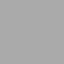

In [9]:
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

nodes = lv.points("nodes", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(mesh.points)

tris = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(mesh.points)
tris.indices(mesh.simplices)
tris.values(grid_z1, label="cubic")
tris.values(grid_z2, label="cubic_tension")
tris.values(grid_z1 - grid_z2, label="delta")

tris.colourmap("#990000 #FFFFFF #000099")
cb = tris.colourbar()

# view the pole

lv.translation(0.0, 0.0, -3.0)
lv.rotation(-20, 0.0, 0.0)



lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
tris.control.List(options=["original", "cubic", "cubic_tension", "delta"],
                  property="colourby", value="original", command="redraw")
lv.control.show()

## Gradients with tension

Pass `sigma` to the following routines that involve derivatives:

- `gradient_lonlat`
- `gradient_xyz`
- `derivatives_lonlat`

Again, the largest difference is visible at the poles.

In [10]:
dlon1, dlat1 = mesh.gradient_lonlat(data, nit=5, tol=1e-6) # no tension
dlon2, dlat2 = mesh.gradient_lonlat(data, nit=5, tol=1e-6, sigma=sigma) # tension

LavaVu Run error: Error creating OpenGL context




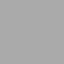

In [11]:
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

nodes = lv.points("nodes", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(mesh.points)

tris = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(mesh.points)
tris.indices(mesh.simplices)
tris.values(dlon1, label="dlon")
tris.values(dlat1, label="dlat")
tris.values(dlon2, label="dlon_tension")
tris.values(dlat2, label="dlat_tension")
tris.values(dlon1 - dlon2, label="dlon_err")
tris.values(dlat1 - dlat2, label="dlat_err")

tris.colourmap("#990000 #FFFFFF #000099")
cb = tris.colourbar()

# view the pole

lv.translation(0.0, 0.0, -3.0)
lv.rotation(-20, 0.0, 0.0)



lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
tris.control.List(options=["original", "dlon", "dlat", "dlon_tension", "dlat_tension", "dlon_err", "dlat_err"],
                  property="colourby", value="original", command="redraw")
lv.control.show()

The next notebook is [Ex9-Voronoi-Diagram](Ex9-Voronoi-Diagram.md)

In [12]:
vdisplay.stop()

NameError: name 'vdisplay' is not defined